In [1]:
# System
import os
import random
import shutil

# Data preparation
import pandas as pd
import numpy as np
import math
from scipy.special import binom, comb

# Plotting
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import svgutils.compose as sc
from IPython.display import SVG

# Calculations: Normalization, cosine distance
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Settings
%matplotlib inline
rcParams['figure.figsize'] = 8, 8
# sns.set_style('whitegrid')

# Custom
from recreate_icip2022_face_reconstruction.GenerateSampleImages import GenerateSampleImagesFromEmbeddings
from recreate_icip2022_face_reconstruction.src.pemiu.privacy_enhancing_miu import PrivacyEnhancingMIU
from recreate_icip2022_face_reconstruction.src.GenerateEmbeddings import GenerateEmbeddings

pd.set_option("display.max_colwidth", 10000)

---

## Investigation of fixed seed in PE-MIU shuffle method

Block size 32

In [2]:
# Global variables
block_sizes = ["16", "32", "64", "128"]
block_size = 32
experiment_appendix = f"exp13_{block_size}"
face_extractor = "arcface"

# Paths
experiment_path = "../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/"
os.makedirs(experiment_path, exist_ok=True)

In [3]:
# Helper methods

def one_sample_per_subject(dataframe, evaluation_criteria: str):
    """
    Return a dataframe of LFW image set with only one sample per subject.
    If a subject has more than one sample, it is compared to the other choices by the provided evaluation criterion.

    Args:
        dataframe ():
        evaluation_criteria (): Dataframe column name. Valid choices, e.g.:
                                - img_original_quality

    Returns: pd.DataFrame
    """
    # Dataset should only include one sample per subject
    # Create a dict with name of subject as key and an empty list as value
    subjects = dataframe['filename'].apply(lambda x: x.split('_')[:-1]).tolist()
    subjects = ['_'.join(x) for x in subjects]
    indices = [[] for _ in range(len(subjects))]
    subjects_dict = dict(zip(subjects, indices))
    # Store row indices for each subject as values
    for index, row in dataframe.iterrows():
        if '_'.join(row['filename'].split('_')[:-1]) in subjects_dict:
            subjects_dict['_'.join(row['filename'].split('_')[:-1])].append(index)
    # Iterate over dict, remove all values except one for each key
    for key, value in subjects_dict.items():
        if len(value) > 1:
            # We keep the sample with the greatest value considering the evaluation criteria
            # Get all rows for indices of this subject as series.
            data = dataframe.iloc[subjects_dict[key]]
            # Get the index of the sample with the greatest value considering the criteria
            # Reduce the values to the chosen sample.
            subjects_dict[key] = [data[evaluation_criteria].idxmax()]
    # Iterate over dataframe.
    # Remove all rows which are not in the dictionary containing only unique subjects and samples
    for index, row in dataframe.iterrows():
        if [index] not in subjects_dict.values():
            dataframe.drop(index, inplace=True)

    return dataframe

In [4]:
# Load and modify dataframes
df = pd.read_csv("../evaluation/lfw_complete_genders_with_quality.csv", sep=",")
df = df[['lfw_image', 'img_original_quality', 'lfw_embedding', 'lfw_filename_raw', 'gender_official']]

# Add filename, remove file extension
df['filename'] = df['lfw_filename_raw'].apply(lambda x: x.split('.')[0])
df.drop(columns='lfw_filename_raw', inplace=True)

df.rename(columns={'lfw_embedding': 'embedding_original_arcface'}, inplace=True)
df.rename(columns={'lfw_image': 'img_original'}, inplace=True)

df['embedding_original_elasticface'] = df['filename'].apply(lambda x: f"../data/lfw_align_embeddings_elastic/{x}.npy")

# Only include one sample per identity: the one with the highest image quality.
df = one_sample_per_subject(df, "img_original_quality")

# Balance dataset to include a 50/50 amount of male and female samples
num_female = len(df[df["gender_official"] == "F"])
# Get indices of rows with male gender
male_indices = df[df['gender_official'] == "M"].index
# Reduce amount of male indices so that the total matches the number of female samples
male_indices = male_indices[num_female:]
# Drop superfluous indices
df = df.drop(male_indices)

# Samples have missing genders. Drop them.
df = df.drop(df[df['gender_official'] == "X"].index)

# Reset df index
df.reset_index(drop=True, inplace=True)

df

,img_original,img_original_quality,embedding_original_arcface,gender_official,filename,embedding_original_elasticface
0,../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_0001.png,0.785188,../data/features_cleaner/Aaron_Eckhart_0001.npy,M,Aaron_Eckhart_0001,../data/lfw_align_embeddings_elastic/Aaron_Eckhart_0001.npy
1,../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001.png,0.764814,../data/features_cleaner/Aaron_Guiel_0001.npy,M,Aaron_Guiel_0001,../data/lfw_align_embeddings_elastic/Aaron_Guiel_0001.npy
2,../data/lfw_align/Aaron_Patterson/Aaron_Patterson_0001.png,0.737193,../data/features_cleaner/Aaron_Patterson_0001.npy,M,Aaron_Patterson_0001,../data/lfw_align_embeddings_elastic/Aaron_Patterson_0001.npy
3,../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_0004.png,0.810206,../data/features_cleaner/Aaron_Peirsol_0004.npy,M,Aaron_Peirsol_0004,../data/lfw_align_embeddings_elastic/Aaron_Peirsol_0004.npy
4,../data/lfw_align/Aaron_Pena/Aaron_Pena_0001.png,0.829048,../data/features_cleaner/Aaron_Pena_0001.npy,M,Aaron_Pena_0001,../data/lfw_align_embeddings_elastic/Aaron_Pena_0001.npy
...,...,...,...,...,...,...
2937,../data/lfw_align/Zelma_Novelo/Zelma_Novelo_0001.png,0.834612,../data/features_cleaner/Zelma_Novelo_0001.npy,F,Zelma_Novelo_0001,../data/lfw_align_embeddings_elastic/Zelma_Novelo_0001.npy
2938,../data/lfw_align/Zhang_Ziyi/Zhang_Ziyi_0003.png,0.696282,../data/features_cleaner/Zhang_Ziyi_0003.npy,F,Zhang_Ziyi_0003,../data/lfw_align_embeddings_elastic/Zhang_Ziyi_0003.npy
2939,../data/lfw_align/Zoe_Ball/Zoe_Ball_0001.png,0.779261,../data/features_cleaner/Zoe_Ball_0001.npy,F,Zoe_Ball_0001,../data/lfw_align_embeddings_elastic/Zoe_Ball_0001.npy
2940,../data/lfw_align/Zorica_Radovic/Zorica_Radovic_0001.png,0.741519,../data/features_cleaner/Zorica_Radovic_0001.npy,F,Zorica_Radovic_0001,../data/lfw_align_embeddings_elastic/Zorica_Radovic_0001.npy


In [5]:
print('Column names:\n')
print('\n'.join(df.columns.to_list()))

Column names:

img_original
img_original_quality
embedding_original_arcface
gender_official
filename
embedding_original_elasticface


---

### Seed discovery

Investigate block size 32 and implications of fixed seed

- Vector length 512
- Block size 32
- Number of possible permutations: 16! (too many to investigate all seeds)
- Assessment from investigation of block size 128: Attack success rate is altered by the amount of blocks shuffled. The position of the blocks has only a low impact on success.

- Look for seeds where none of the blocks has changed positions, then two, then three, and so on

In [9]:
target_a = df.iloc[0:1,:]['embedding_original_arcface'].to_string(header=False, index=False)
target_a

'../data/features_cleaner/Aaron_Eckhart_0001.npy'

In [10]:
target_a = [np.load(target_a)]

In [18]:
# Initialize PE-MIU
pemiu = PrivacyEnhancingMIU(block_size=block_size)
random_results = {}
amount = 10**7
start = time.time()

# Go trough j random seeds, shuffle the vector, store the permutation degree (0, 64, 128, ...)
# Higher result means less permutation
for j in range(0, amount):
    random.seed(j)
    target_a_shuffled = pemiu.shuffle(target_a)
    positions = [target_a[i] == target_a_shuffled[i] for i in range(len(target_a))]
    if sum(positions[0]) not in random_results.values():
        random_results[j] = sum(positions[0])
    if j % 10**4 == 0:
        end = time.time()
        clear_output(wait=True)
        percent = (round(j / amount * 100, 2))
        print("Done with", percent, "% at", round(end - start, 2), "sec")

Done with 4.2 % at 29.66 sec


KeyboardInterrupt: 

In [14]:
# Create a dict with the seeds and description
seed_dict = {}
max_range = int(512 / block_size + 1)
permutation_degree = [x * block_size for x in range(0, max_range)]

# Go through seeds, take one seed for each permutation degree
for k, v in random_results.items():
    if v in permutation_degree:
        seed_dict[k] = v
        permutation_degree.remove(v)

In [15]:
# Permutation degrees that coudn't be found
permutation_degree

[288, 320, 352, 384, 416, 448, 480, 512]

In [16]:
# Sort dict by permutation degree
seed_dict = dict(sorted(seed_dict.items(), key=lambda item: item[1], reverse=True))

In [117]:
# Seeds and their permutation degree
for key, value in seed_dict.items():
    print(key, "\t",value)

422444 	 320
2015268 	 288
73103 	 256
15134 	 224
271 	 192
466 	 160
5 	 128
1 	 96
6 	 64
2 	 32
0 	 0


In [17]:
len(seed_dict)

9

In [6]:
# Load existing seeds
path = "../evaluation/seed_discovery_32.txt"
with open(path, 'r') as file:
    lines = file.readlines()

seed_dict_load = {}
for line in lines:
    degree = line.split(' ')[2]
    seed_dict_load[int(line.split(' ')[0])] = int(degree)
    
seed_dict_load

{50343053: 384,
 52115862: 352,
 422444: 320,
 2015268: 288,
 73103: 256,
 15134: 224,
 271: 192,
 466: 160,
 5: 128,
 1: 96,
 6: 64,
 2: 32,
 0: 0}

---

### Probability of occurence

In [87]:
total_permutations = math.factorial(len(seed_dict))
print("Total possible permutations:", total_permutations)

Total possible permutations: 40320


In [139]:
amount = len(seed_dict)
for key, _ in seed_dict.items():
    result = math.factorial(len(seed_dict)) / (math.factorial(len(seed_dict) - amount))
    percentage = round(result / total_permutations * 100, 3)
    print(f"Amount of permutations when {amount} in {len(seed_dict)} change positions: {'{:g}'.format(result)}")
    
    if not amount == 2:
        amount = amount - 1
    else:
        amount = amount - 2

Amount of permutations when 8 in 8 change positions: 40320
Amount of permutations when 7 in 8 change positions: 40320
Amount of permutations when 6 in 8 change positions: 20160
Amount of permutations when 5 in 8 change positions: 6720
Amount of permutations when 4 in 8 change positions: 1680
Amount of permutations when 3 in 8 change positions: 336
Amount of permutations when 2 in 8 change positions: 56
Amount of permutations when 0 in 8 change positions: 1


---

### Create PE-MIU embeddings with known seeds

In [39]:
for key, value in seed_dict_load.items():
    # Make dir
    save_path = f"{experiment_path}embedding_seed_{key}"
    os.makedirs(save_path, exist_ok=True)
    
    # Shuffle Pemiu with seed key for each embedding
    embeddings = [np.load(x) for x in df['embedding_original_arcface'].to_list()]
    embeddings_shuffled = []
    for element in embeddings:
        random.seed(key)
        embeddings_shuffled.append(pemiu.shuffle([element]))
    [np.save(f"{save_path}/{df['filename'][i]}.npy", embeddings_shuffled[i]) for i in range(len(df))]

---

### Create image reconsutrctions and evaluate cosine similarity

In [40]:
for key, value in seed_dict_load.items():
    samples = GenerateSampleImagesFromEmbeddings(
        dataset_dir=experiment_path,
        embedding_dir=f"embedding_seed_{key}",
        image_dir=f"../data/lfw_align",
        file_appendix=f"{experiment_appendix}",
        save_path=f"{experiment_path}/sample_img_{key}",
        save_path_log=f"{experiment_path}/sample_img_{key}",
        generator_checkpoint_dir="../recreate_icip2022_face_reconstruction/training_files",
        epoch=90,
        write_original_img=False,
        create_subdirs=False,
        batch_size=32
    )
    samples.generate()

The torch device is: cuda
Generating around 2944 samples
Done

The torch device is: cuda
Generating around 2944 samples
Done

The torch device is: cuda
Generating around 2944 samples
Done

The torch device is: cuda
Generating around 2944 samples
Done

The torch device is: cuda
Generating around 2944 samples
Done

The torch device is: cuda
Generating around 2944 samples
Done

The torch device is: cuda
Generating around 2944 samples
Done

The torch device is: cuda
Generating around 2944 samples
Done

The torch device is: cuda
Generating around 2944 samples
Done

The torch device is: cuda
Generating around 2944 samples
Done

The torch device is: cuda
Generating around 2944 samples
Done

The torch device is: cuda
Generating around 2944 samples
Done

The torch device is: cuda
Generating around 2944 samples
Done



---

### Evaluate

In [7]:
for key, value in seed_dict_load.items():
    # Load results
    df_results = pd.read_csv(f"{experiment_path}/sample_img_{key}/logs/sample_images_log_{experiment_appendix}.csv")
    # Append results to dataframe
    df[f'seed_{key}'] = df_results['Cosine Distance Bona Fide Embedding vs Synthesised Image Embedding']

In [42]:
# Calculate mean of cos_sim and std deviation
df_eval = pd.DataFrame()
for key, value in seed_dict.items():
    df_eval[f'seed_{key}_cos_sim_mean'] = [df[f'seed_{key}'].mean()]
    df_eval[f'seed_{key}_cos_sim_std'] = [df[f'seed_{key}'].std()]

In [43]:
df_eval.T

,0
seed_73103_cos_sim_mean,0.270671
seed_73103_cos_sim_std,0.098699
seed_15134_cos_sim_mean,0.238510
seed_15134_cos_sim_std,0.095363
seed_271_cos_sim_mean,0.212376
seed_271_cos_sim_std,0.091677
seed_466_cos_sim_mean,0.178804
seed_466_cos_sim_std,0.086171
seed_5_cos_sim_mean,0.142940
seed_5_cos_sim_std,0.082350


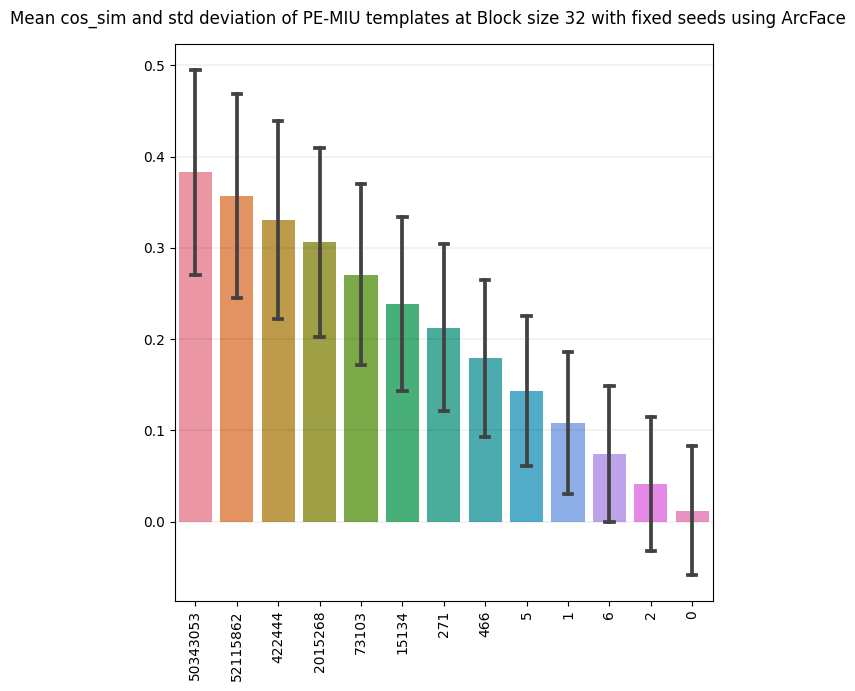

In [44]:
fig, ax = plt.subplots(1, 1, figsize = (6, 7), tight_layout = True)
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
labels = [x.split('_')[1] for x in df[df.columns[pd.Series(df.columns).str.startswith('seed_')]].columns.to_list()]
sns.barplot(data=df[df.columns[pd.Series(df.columns).str.startswith('seed_')]], 
            ax=ax, 
            estimator=np.mean, errorbar=('sd'), capsize=.2)
ax.set_xticklabels(labels, rotation=90)
fig.suptitle(f"Mean cos_sim and std deviation of PE-MIU templates at Block size {block_size} with fixed seeds using ArcFace")

# Thresholds
#for i, (th, value) in enumerate(zip(['FMR1000_TH', 'FMR100_TH', 'FMR10_TH'], [0.25, 0.17, 0.1])):
#    ax.axhline(y = value, 
#               color = sns.color_palette("colorblind")[i], linestyle="--",
#               label = f"{th}: {value}")
#ax.legend()

plt.show()

### Evaluate attack success rate

In [10]:
df

,img_original,img_original_quality,embedding_original_arcface,gender_official,filename,embedding_original_elasticface,seed_50343053,seed_52115862,seed_422444,seed_2015268,seed_73103,seed_15134,seed_271,seed_466,seed_5,seed_1,seed_6,seed_2,seed_0
0,../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_...,0.785188,../data/features_cleaner/Aaron_Eckhart_0001.npy,M,Aaron_Eckhart_0001,../data/lfw_align_embeddings_elastic/Aaron_Eck...,0.371,0.358,0.254,0.239,0.219,0.145,0.219,0.225,0.070,0.060,0.205,0.008,0.099
1,../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001...,0.764814,../data/features_cleaner/Aaron_Guiel_0001.npy,M,Aaron_Guiel_0001,../data/lfw_align_embeddings_elastic/Aaron_Gui...,0.246,0.253,0.239,0.190,0.153,0.213,0.179,0.183,0.117,0.158,0.091,0.017,-0.065
2,../data/lfw_align/Aaron_Patterson/Aaron_Patter...,0.737193,../data/features_cleaner/Aaron_Patterson_0001.npy,M,Aaron_Patterson_0001,../data/lfw_align_embeddings_elastic/Aaron_Pat...,0.322,0.205,0.120,0.152,0.220,0.180,0.103,-0.018,0.035,0.098,-0.038,-0.042,0.021
3,../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_...,0.810206,../data/features_cleaner/Aaron_Peirsol_0004.npy,M,Aaron_Peirsol_0004,../data/lfw_align_embeddings_elastic/Aaron_Pei...,0.306,0.354,0.241,0.222,0.310,0.248,0.196,0.224,0.059,-0.026,0.089,0.057,-0.034
4,../data/lfw_align/Aaron_Pena/Aaron_Pena_0001.png,0.829048,../data/features_cleaner/Aaron_Pena_0001.npy,M,Aaron_Pena_0001,../data/lfw_align_embeddings_elastic/Aaron_Pen...,0.352,0.342,0.297,0.340,0.304,0.138,0.413,0.340,0.134,0.003,0.154,-0.047,-0.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,../data/lfw_align/Zelma_Novelo/Zelma_Novelo_00...,0.834612,../data/features_cleaner/Zelma_Novelo_0001.npy,F,Zelma_Novelo_0001,../data/lfw_align_embeddings_elastic/Zelma_Nov...,0.452,0.590,0.407,0.481,0.312,0.310,0.285,0.115,0.283,0.207,0.215,0.004,0.070
2939,../data/lfw_align/Zhang_Ziyi/Zhang_Ziyi_0003.png,0.696282,../data/features_cleaner/Zhang_Ziyi_0003.npy,F,Zhang_Ziyi_0003,../data/lfw_align_embeddings_elastic/Zhang_Ziy...,0.262,0.153,0.144,0.247,0.175,0.139,0.234,0.232,0.146,0.085,-0.030,0.019,-0.033
2940,../data/lfw_align/Zoe_Ball/Zoe_Ball_0001.png,0.779261,../data/features_cleaner/Zoe_Ball_0001.npy,F,Zoe_Ball_0001,../data/lfw_align_embeddings_elastic/Zoe_Ball_...,0.433,0.361,0.283,0.449,0.528,0.318,0.247,0.233,0.162,0.100,0.154,0.056,-0.109
2941,../data/lfw_align/Zorica_Radovic/Zorica_Radovi...,0.741519,../data/features_cleaner/Zorica_Radovic_0001.npy,F,Zorica_Radovic_0001,../data/lfw_align_embeddings_elastic/Zorica_Ra...,0.513,0.406,0.313,0.500,0.352,0.347,0.141,0.211,0.166,0.139,0.059,-0.006,-0.003


In [34]:
df_fmr1000, df_fmr100, df_fmr10 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for th_label, th_value in zip(['FMR1000_TH', 'FMR100_TH', 'FMR10_TH'], [0.25, 0.17, 0.1]):
    print(th_label)
    for key, value in seed_dict_load.items():
        # Load results
        # df_results = pd.read_csv(f"{experiment_path}/sample_img_{key}/logs/sample_images_log_{experiment_appendix}.csv")
        # Append results to dataframe
        length = len(df)
        success = len(df[df[f'seed_{key}'] > th_value])
        print(f"Seed: {key}     \t Attack success rate: {round(success / length * 100, 2)}%")
        if th_label == "FMR1000_TH":
            df_fmr1000[key] = [round(success / length * 100, 2)]
        elif th_label == "FMR100_TH":
            df_fmr100[key] = [round(success / length * 100, 2)]
        elif th_label == "FMR10_TH":
            df_fmr10[key] = [round(success / length * 100, 2)]
    print("\n")

FMR1000_TH
Seed: 50343053     	 Attack success rate: 89.09%
Seed: 52115862     	 Attack success rate: 84.06%
Seed: 422444     	 Attack success rate: 78.59%
Seed: 2015268     	 Attack success rate: 70.85%
Seed: 73103     	 Attack success rate: 58.44%
Seed: 15134     	 Attack success rate: 43.56%
Seed: 271     	 Attack success rate: 32.79%
Seed: 466     	 Attack success rate: 20.42%
Seed: 5     	 Attack success rate: 9.68%
Seed: 1     	 Attack success rate: 3.67%
Seed: 6     	 Attack success rate: 1.39%
Seed: 2     	 Attack success rate: 0.44%
Seed: 0     	 Attack success rate: 0.0%


FMR100_TH
Seed: 50343053     	 Attack success rate: 96.64%
Seed: 52115862     	 Attack success rate: 95.45%
Seed: 422444     	 Attack success rate: 93.51%
Seed: 2015268     	 Attack success rate: 90.59%
Seed: 73103     	 Attack success rate: 85.39%
Seed: 15134     	 Attack success rate: 76.18%
Seed: 271     	 Attack success rate: 67.01%
Seed: 466     	 Attack success rate: 52.97%
Seed: 5     	 Attack succes

In [35]:
# Permutation complexity
permutation_complexity = [x for x in range(0, 17)]
# permutation_complexity.remove([3, 2, 1, 0])
del permutation_complexity[1:4]
permutation_complexity

[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [27]:
len(seed_dict_load)

13

In [28]:
len(permutation_complexity)

14

In [36]:
# Add value for seed where vector is unchanged
df_fmr10.insert(loc=0, column='seed_unchanged', value=99.01)
df_fmr100.insert(loc=0, column='seed_unchanged', value=97.52)
df_fmr1000.insert(loc=0, column='seed_unchanged', value=95.04)

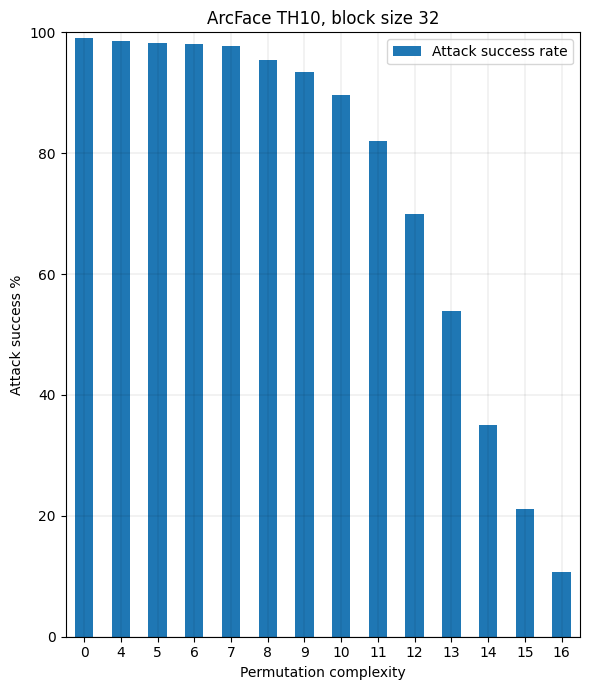

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (6, 7), tight_layout = True)
df_fmr10.T.plot(kind='bar', ax=ax,  title=f"ArcFace TH10, block size {block_size}", label='seed')
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
ax.legend(["Attack success rate"])
ax.set_ylim([0, 100])
ax.set_xticklabels([f"{complexity}" for seed, complexity in zip(df_fmr10.columns.to_list(), permutation_complexity)], rotation=0)
ax.set_xlabel("Permutation complexity")
ax.set_ylabel("Attack success %")
plt.show()

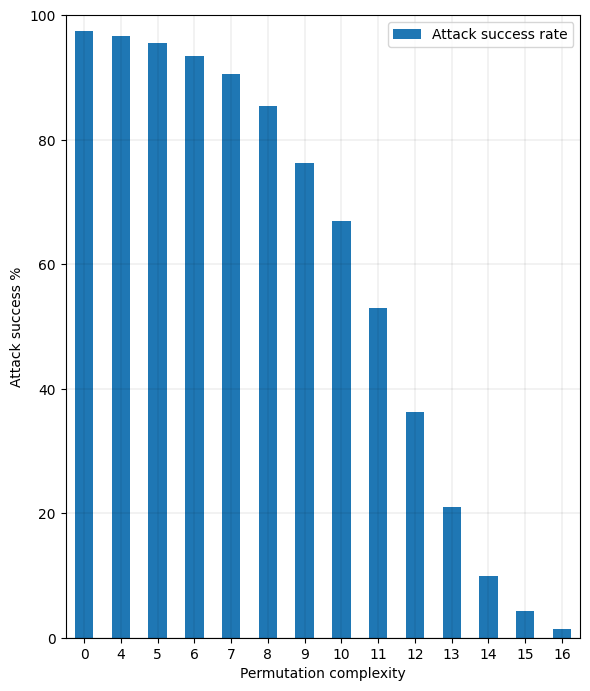

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (6, 7), tight_layout = True)
df_fmr100.T.plot(kind='bar', ax=ax,   label='seed')
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
ax.legend(["Attack success rate"])
ax.set_ylim([0, 100])
ax.set_xticklabels([f"{complexity}" for seed, complexity in zip(df_fmr100.columns.to_list(), permutation_complexity)], rotation=0)
ax.set_xlabel("Permutation complexity")
ax.set_ylabel("Attack success %")
plt.savefig(f'random_seed_investigation/seed_{face_extractor}_32_th100.svg', bbox_inches='tight')
plt.show()

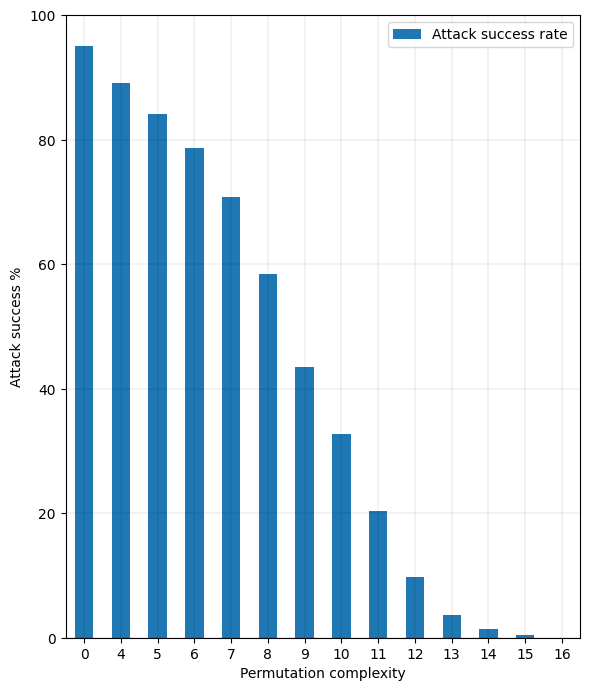

In [42]:
fig, ax = plt.subplots(1, 1, figsize = (6, 7), tight_layout = True)
df_fmr1000.T.plot(kind='bar', ax=ax,   label='seed')
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
ax.legend(["Attack success rate"])
ax.set_ylim([0, 100])
ax.set_xticklabels([f"{complexity}" for seed, complexity in zip(df_fmr1000.columns.to_list(), permutation_complexity)], rotation=0)
ax.set_xlabel("Permutation complexity")
ax.set_ylabel("Attack success %")
plt.savefig(f'random_seed_investigation/seed_{face_extractor}_32_th1000.svg', bbox_inches='tight')
plt.show()

### Export

In [27]:
df

,img_original,img_original_quality,embedding_original_arcface,gender_official,filename,embedding_original_elasticface,seed_50343053,seed_52115862,seed_422444,seed_2015268,seed_73103,seed_15134,seed_271,seed_466,seed_5,seed_1,seed_6,seed_2,seed_0
0,../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_0001.png,0.785188,../data/features_cleaner/Aaron_Eckhart_0001.npy,M,Aaron_Eckhart_0001,../data/lfw_align_embeddings_elastic/Aaron_Eckhart_0001.npy,0.371,0.358,0.254,0.239,0.219,0.145,0.219,0.225,0.070,0.060,0.205,0.008,0.099
1,../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001.png,0.764814,../data/features_cleaner/Aaron_Guiel_0001.npy,M,Aaron_Guiel_0001,../data/lfw_align_embeddings_elastic/Aaron_Guiel_0001.npy,0.246,0.253,0.239,0.190,0.153,0.213,0.179,0.183,0.117,0.158,0.091,0.017,-0.065
2,../data/lfw_align/Aaron_Patterson/Aaron_Patterson_0001.png,0.737193,../data/features_cleaner/Aaron_Patterson_0001.npy,M,Aaron_Patterson_0001,../data/lfw_align_embeddings_elastic/Aaron_Patterson_0001.npy,0.322,0.205,0.120,0.152,0.220,0.180,0.103,-0.018,0.035,0.098,-0.038,-0.042,0.021
3,../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_0004.png,0.810206,../data/features_cleaner/Aaron_Peirsol_0004.npy,M,Aaron_Peirsol_0004,../data/lfw_align_embeddings_elastic/Aaron_Peirsol_0004.npy,0.306,0.354,0.241,0.222,0.310,0.248,0.196,0.224,0.059,-0.026,0.089,0.057,-0.034
4,../data/lfw_align/Aaron_Pena/Aaron_Pena_0001.png,0.829048,../data/features_cleaner/Aaron_Pena_0001.npy,M,Aaron_Pena_0001,../data/lfw_align_embeddings_elastic/Aaron_Pena_0001.npy,0.352,0.342,0.297,0.340,0.304,0.138,0.413,0.340,0.134,0.003,0.154,-0.047,-0.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,../data/lfw_align/Zelma_Novelo/Zelma_Novelo_0001.png,0.834612,../data/features_cleaner/Zelma_Novelo_0001.npy,F,Zelma_Novelo_0001,../data/lfw_align_embeddings_elastic/Zelma_Novelo_0001.npy,0.369,0.340,0.285,0.395,0.398,0.312,0.126,0.031,0.018,0.163,0.126,0.014,-0.015
2938,../data/lfw_align/Zhang_Ziyi/Zhang_Ziyi_0003.png,0.696282,../data/features_cleaner/Zhang_Ziyi_0003.npy,F,Zhang_Ziyi_0003,../data/lfw_align_embeddings_elastic/Zhang_Ziyi_0003.npy,0.452,0.590,0.407,0.481,0.312,0.310,0.285,0.115,0.283,0.207,0.215,0.004,0.070
2939,../data/lfw_align/Zoe_Ball/Zoe_Ball_0001.png,0.779261,../data/features_cleaner/Zoe_Ball_0001.npy,F,Zoe_Ball_0001,../data/lfw_align_embeddings_elastic/Zoe_Ball_0001.npy,0.262,0.153,0.144,0.247,0.175,0.139,0.234,0.232,0.146,0.085,-0.030,0.019,-0.033
2940,../data/lfw_align/Zorica_Radovic/Zorica_Radovic_0001.png,0.741519,../data/features_cleaner/Zorica_Radovic_0001.npy,F,Zorica_Radovic_0001,../data/lfw_align_embeddings_elastic/Zorica_Radovic_0001.npy,0.433,0.361,0.283,0.449,0.528,0.318,0.247,0.233,0.162,0.100,0.154,0.056,-0.109


In [28]:
# seed_no = 52115862
seed_no = 0
# permutation_compexity_no = 4
permutation_compexity_no = 16

df_export = df[['embedding_original_arcface', 'gender_official', 'filename', f'seed_{seed_no}']]
df_export.rename(columns={f'seed_{seed_no}': f'cos_sim_permutation_complexity_{permutation_compexity_no}'}, inplace=True)
df_export[f'embedding_pemiu_{block_size}_seed{seed_no}'] = df_export['filename'].apply(lambda x: f"{experiment_path}embedding_seed_{seed_no}/{x}.npy")

# Include filepath for image reconstructions at permutation complexity 4
df_results_seed = pd.read_csv(f"{experiment_path}/sample_img_{seed_no}/logs/sample_images_log_exp13_{block_size}.csv")
df_results_seed.rename(columns={'filename': f'reconstructed_img_from_embedding_perm_compl_{permutation_compexity_no}'}, inplace=True)
df_results_seed['filename'] = df_results_seed[f'reconstructed_img_from_embedding_perm_compl_{permutation_compexity_no}'].apply(lambda x: x.split('_exp13_')[0])
df_export = df_export.merge(df_results_seed[['filename', f'reconstructed_img_from_embedding_perm_compl_{permutation_compexity_no}']], on='filename')
df_export[f'reconstructed_img_from_embedding_perm_compl_{permutation_compexity_no}'] = df_export[f'reconstructed_img_from_embedding_perm_compl_{permutation_compexity_no}'].apply(lambda x: f'{experiment_path}sample_img_{seed_no}/{x}')
df_export

/tmp/ipykernel_1641/4267237837.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export.rename(columns={f'seed_{seed_no}': f'cos_sim_permutation_complexity_{permutation_compexity_no}'}, inplace=True)
/tmp/ipykernel_1641/4267237837.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export[f'embedding_pemiu_{block_size}_seed{seed_no}'] = df_export['filename'].apply(lambda x: f"{experiment_path}embedding_seed_{seed_no}/{x}.npy")


,embedding_original_arcface,gender_official,filename,cos_sim_permutation_complexity_16,embedding_pemiu_32_seed0,reconstructed_img_from_embedding_perm_compl_16
0,../data/features_cleaner/Aaron_Eckhart_0001.npy,M,Aaron_Eckhart_0001,0.099,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Aaron_Eckhart_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Aaron_Eckhart_0001_exp13_32_0000.png
1,../data/features_cleaner/Aaron_Guiel_0001.npy,M,Aaron_Guiel_0001,-0.065,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Aaron_Guiel_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Aaron_Guiel_0001_exp13_32_0001.png
2,../data/features_cleaner/Aaron_Patterson_0001.npy,M,Aaron_Patterson_0001,0.021,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Aaron_Patterson_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Aaron_Patterson_0001_exp13_32_0002.png
3,../data/features_cleaner/Aaron_Peirsol_0004.npy,M,Aaron_Peirsol_0004,-0.034,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Aaron_Peirsol_0004.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Aaron_Peirsol_0004_exp13_32_0003.png
4,../data/features_cleaner/Aaron_Pena_0001.npy,M,Aaron_Pena_0001,-0.012,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Aaron_Pena_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Aaron_Pena_0001_exp13_32_0004.png
...,...,...,...,...,...,...
2937,../data/features_cleaner/Zelma_Novelo_0001.npy,F,Zelma_Novelo_0001,-0.015,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Zelma_Novelo_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Zelma_Novelo_0001_exp13_32_0026.png
2938,../data/features_cleaner/Zhang_Ziyi_0003.npy,F,Zhang_Ziyi_0003,0.070,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Zhang_Ziyi_0003.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Zhang_Ziyi_0003_exp13_32_0027.png
2939,../data/features_cleaner/Zoe_Ball_0001.npy,F,Zoe_Ball_0001,-0.033,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Zoe_Ball_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Zoe_Ball_0001_exp13_32_0028.png
2940,../data/features_cleaner/Zorica_Radovic_0001.npy,F,Zorica_Radovic_0001,-0.109,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Zorica_Radovic_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Zorica_Radovic_0001_exp13_32_0029.png


In [29]:
# Generate embeddings from reconstructed images
gen_emb = GenerateEmbeddings()
path = f'{experiment_path}sample_img_{seed_no}_embeddings'
os.makedirs(path, exist_ok=True)

for image, filename in zip(df_export[f'reconstructed_img_from_embedding_perm_compl_{permutation_compexity_no}'].tolist(), df_export['filename'].tolist()):
    embedding = gen_emb.embedding_from_img(image)
    np.save(f"{path}/{filename}.npy", embedding)

The torch device is: cuda


In [30]:
df_export['embeddings_from_reconsutrcted_img'] = df_export['filename'].apply(lambda x: f'{experiment_path}sample_img_{seed_no}_embeddings/{x}.npy')
df_export

,embedding_original_arcface,gender_official,filename,cos_sim_permutation_complexity_16,embedding_pemiu_32_seed0,reconstructed_img_from_embedding_perm_compl_16,embeddings_from_reconsutrcted_img
0,../data/features_cleaner/Aaron_Eckhart_0001.npy,M,Aaron_Eckhart_0001,0.099,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Aaron_Eckhart_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Aaron_Eckhart_0001_exp13_32_0000.png,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0_embeddings/Aaron_Eckhart_0001.npy
1,../data/features_cleaner/Aaron_Guiel_0001.npy,M,Aaron_Guiel_0001,-0.065,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Aaron_Guiel_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Aaron_Guiel_0001_exp13_32_0001.png,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0_embeddings/Aaron_Guiel_0001.npy
2,../data/features_cleaner/Aaron_Patterson_0001.npy,M,Aaron_Patterson_0001,0.021,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Aaron_Patterson_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Aaron_Patterson_0001_exp13_32_0002.png,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0_embeddings/Aaron_Patterson_0001.npy
3,../data/features_cleaner/Aaron_Peirsol_0004.npy,M,Aaron_Peirsol_0004,-0.034,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Aaron_Peirsol_0004.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Aaron_Peirsol_0004_exp13_32_0003.png,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0_embeddings/Aaron_Peirsol_0004.npy
4,../data/features_cleaner/Aaron_Pena_0001.npy,M,Aaron_Pena_0001,-0.012,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Aaron_Pena_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Aaron_Pena_0001_exp13_32_0004.png,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0_embeddings/Aaron_Pena_0001.npy
...,...,...,...,...,...,...,...
2937,../data/features_cleaner/Zelma_Novelo_0001.npy,F,Zelma_Novelo_0001,-0.015,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Zelma_Novelo_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Zelma_Novelo_0001_exp13_32_0026.png,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0_embeddings/Zelma_Novelo_0001.npy
2938,../data/features_cleaner/Zhang_Ziyi_0003.npy,F,Zhang_Ziyi_0003,0.070,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Zhang_Ziyi_0003.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Zhang_Ziyi_0003_exp13_32_0027.png,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0_embeddings/Zhang_Ziyi_0003.npy
2939,../data/features_cleaner/Zoe_Ball_0001.npy,F,Zoe_Ball_0001,-0.033,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/embedding_seed_0/Zoe_Ball_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0/Zoe_Ball_0001_exp13_32_0028.png,../recreate_icip2022_face_reconstruction/experiments/experiment_13_pemiu_random_32/sample_img_0_embeddings/Zoe_Ball_0001.npy
2940,../data/features_cleaner/Zorica_Radovic_0001.npy,F,Zorica_Radovic_0001,-0.109,../recreate_icip2022_face_reconstr

In [31]:
# Export

face_extractor_name = 'arcface' 
export_path = f"../export/{face_extractor_name}_pemiu{block_size}_permcomp{permutation_compexity_no}_balanced"
os.makedirs(export_path, exist_ok=True)

os.makedirs(f'{export_path}/embeddings_original', exist_ok=True)
os.makedirs(f'{export_path}/embeddings_pemiu', exist_ok=True)
os.makedirs(f'{export_path}/reconstructed_img', exist_ok=True)
os.makedirs(f'{export_path}/embeddings_from_reconstructed_img', exist_ok=True)

In [32]:
# Copy files to export location

for element in df_export[f'embedding_original_{face_extractor_name}'].tolist():
    shutil.copy(element, f'{export_path}/embeddings_original')
    
for element in df_export[f'embedding_pemiu_{block_size}_seed{seed_no}'].tolist():
    shutil.copy(element, f'{export_path}/embeddings_pemiu')
    
for element in df_export[f'reconstructed_img_from_embedding_perm_compl_{permutation_compexity_no}'].tolist():
    shutil.copy(element, f'{export_path}/reconstructed_img')
    
for element in df_export['embeddings_from_reconsutrcted_img'].tolist():
    shutil.copy(element, f'{export_path}/embeddings_from_reconstructed_img')

In [33]:
# Modify dataframe to include relative filepaths

df_export[f'embedding_original_{face_extractor_name}'] = df_export[f'embedding_original_{face_extractor_name}'].apply(lambda x: f"./embeddings_original/{x.split('/')[-1]}")
df_export[f'embedding_pemiu_{block_size}_seed{seed_no}'] = df_export[f'embedding_pemiu_{block_size}_seed{seed_no}'].apply(lambda x: f"./embeddings_pemiu/{x.split('/')[-1]}")
df_export[f'reconstructed_img_from_embedding_perm_compl_{permutation_compexity_no}'] = df_export[f'reconstructed_img_from_embedding_perm_compl_{permutation_compexity_no}'].apply(lambda x: f"./reconstructed_img/{x.split('/')[-1]}")
df_export['embeddings_from_reconsutrcted_img'] = df_export['embeddings_from_reconsutrcted_img'].apply(lambda x: f"./embeddings_from_reconstructed_img/{x.split('/')[-1]}")
df_export

,embedding_original_arcface,gender_official,filename,cos_sim_permutation_complexity_16,embedding_pemiu_32_seed0,reconstructed_img_from_embedding_perm_compl_16,embeddings_from_reconsutrcted_img
0,./embeddings_original/Aaron_Eckhart_0001.npy,M,Aaron_Eckhart_0001,0.099,./embeddings_pemiu/Aaron_Eckhart_0001.npy,./reconstructed_img/Aaron_Eckhart_0001_exp13_32_0000.png,./embeddings_from_reconstructed_img/Aaron_Eckhart_0001.npy
1,./embeddings_original/Aaron_Guiel_0001.npy,M,Aaron_Guiel_0001,-0.065,./embeddings_pemiu/Aaron_Guiel_0001.npy,./reconstructed_img/Aaron_Guiel_0001_exp13_32_0001.png,./embeddings_from_reconstructed_img/Aaron_Guiel_0001.npy
2,./embeddings_original/Aaron_Patterson_0001.npy,M,Aaron_Patterson_0001,0.021,./embeddings_pemiu/Aaron_Patterson_0001.npy,./reconstructed_img/Aaron_Patterson_0001_exp13_32_0002.png,./embeddings_from_reconstructed_img/Aaron_Patterson_0001.npy
3,./embeddings_original/Aaron_Peirsol_0004.npy,M,Aaron_Peirsol_0004,-0.034,./embeddings_pemiu/Aaron_Peirsol_0004.npy,./reconstructed_img/Aaron_Peirsol_0004_exp13_32_0003.png,./embeddings_from_reconstructed_img/Aaron_Peirsol_0004.npy
4,./embeddings_original/Aaron_Pena_0001.npy,M,Aaron_Pena_0001,-0.012,./embeddings_pemiu/Aaron_Pena_0001.npy,./reconstructed_img/Aaron_Pena_0001_exp13_32_0004.png,./embeddings_from_reconstructed_img/Aaron_Pena_0001.npy
...,...,...,...,...,...,...,...
2937,./embeddings_original/Zelma_Novelo_0001.npy,F,Zelma_Novelo_0001,-0.015,./embeddings_pemiu/Zelma_Novelo_0001.npy,./reconstructed_img/Zelma_Novelo_0001_exp13_32_0026.png,./embeddings_from_reconstructed_img/Zelma_Novelo_0001.npy
2938,./embeddings_original/Zhang_Ziyi_0003.npy,F,Zhang_Ziyi_0003,0.070,./embeddings_pemiu/Zhang_Ziyi_0003.npy,./reconstructed_img/Zhang_Ziyi_0003_exp13_32_0027.png,./embeddings_from_reconstructed_img/Zhang_Ziyi_0003.npy
2939,./embeddings_original/Zoe_Ball_0001.npy,F,Zoe_Ball_0001,-0.033,./embeddings_pemiu/Zoe_Ball_0001.npy,./reconstructed_img/Zoe_Ball_0001_exp13_32_0028.png,./embeddings_from_reconstructed_img/Zoe_Ball_0001.npy
2940,./embeddings_original/Zorica_Radovic_0001.npy,F,Zorica_Radovic_0001,-0.109,./embeddings_pemiu/Zorica_Radovic_0001.npy,./reconstructed_img/Zorica_Radovic_0001_exp13_32_0029.png,./embeddings_from_reconstructed_img/Zorica_Radovic_0001.npy


In [34]:
df_export.to_csv(f"{export_path}/dataframe.csv")